# 円周率を求めよう！ - Demo of Linear Interpolation Library

Library Info: [https://github.com/myuuuuun/oyama_seminar2016/tree/master/exercise/ex01](https://github.com/myuuuuun/oyama_seminar2016/tree/master/exercise/ex01)  
Code: [https://github.com/myuuuuun/oyama_seminar2016/blob/master/exercise/ex01/ex01.jl](https://github.com/myuuuuun/oyama_seminar2016/blob/master/exercise/ex01/ex01.jl)

In [1]:
using Gadfly
using Distributions
set_default_plot_size(18cm, 12cm)
include("ex01.jl")

LinearInterpolation

### ライブラリの中身: 

In [2]:
;cat ex01.jl

#-*- encoding: utf-8 -*-
# linear interpolation
# more info: https://github.com/myuuuuun/oyama_seminar2016/tree/master/exercise/ex01
#
# last update: 2017/5/6, supporting julia v0.5
# 
# Copyright (c) 2016 @myuuuuun
# Released under the MIT license.


module LinearInterpolation

immutable LinInterp
    grid::Array
    vals::Array
end

function (points::LinInterp)(x::Real)
    grid = points.grid; vals = points.vals
    lower_index = searchsortedlast(points.grid, x)

    # 補外に対応
    if lower_index == 0 
        lower_index = 1
    elseif lower_index == length(grid)
        lower_index = length(grid) - 1
    end

    upper_index = lower_index + 1
    grid_step = grid[upper_index] - grid[lower_index]
    val_step = vals[upper_index] - vals[lower_index]
    iterp_val = vals[lower_index] + (val_step / grid_step) * (x - grid[lower_index])

    return iterp_val
end

end

## 0. やりたいこと

定積分

$$
4 \times \int_0^1 \cfrac{1}{1 + x^2} \ dx = \pi
$$

を折れ線近似による積分を使って数値計算することで, 円周率を求めたい. ついでに折れ線近似による積分の近似誤差について考えたい.

In [3]:
func(x) = 1 ./ (1 .+ x.^2)
n = 10000
step = 1 / n
grid = linspace(0, 1, n+1)
vals = func(grid)

s = sum(vals[2:n]) + 0.5 * (vals[1] + vals[n+1])

approx_pi = step * s * 4
println(approx_pi )

3.1415926519231263


モンテカルロ法で円周率を計算するよりも（かなり）まし.

## 1. 台形則と複合台形則

### 1.1 台形則

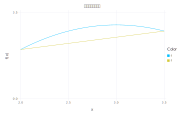

In [4]:
# f(x) = -(x-3)^2 + 3
f(x) = -1 .* (x-3).^2 .+ 3
a = 2
b = 3.5

# 端点とその関数値
grid = [a, b]
vals = f(grid)

# plotがFunctionしか受け付けてくれないので関数化
oresen1 = LinearInterpolation.LinInterp(grid, vals)
g(x) = oresen1.(x)

# plot
plot([f, g], a, b, Guide.yticks(ticks=[0, 3.5]), Guide.Title("台形則のイメージ"))

ある1変数関数  $f: \mathbb{R} \rightarrow \mathbb{R}$ の $x \in [a, b]$ における定積分

$$
T = \int_a^b f(x) \ dx
$$

を, 両端点を結ぶ直線の関数

$$
g(x) = \cfrac{f(b) - f(a)}{b - a} (x - a) + f(a)
$$ 

の積分

$$
\hat{T} = \int_a^b g(x) \ dx = \cfrac{f(a) + f(b)}{2} (b - a)
$$

で近似することを考える.

真の関数 $f(x)$ の積分値 $T$ と, 近似関数 $g(x)$ の積分値 $\hat{T}$ がどのくらい離れているかを評価したい. 

まず, $x = a + t$ と置き換えると, 

$$
\begin{eqnarray}
T - \hat{T} &=& \int_{a}^{b} f(x) - g(x) \ dx = \int_{0}^{b-a} f(a + t) - g(a + t) \ dt
\end{eqnarray}
$$

と変換できる.

ここで, $f$ が定義域で2回連続微分可能であることを仮定すれば, $f(a+t)$ を $t=a$ のまわりで Taylor展開すると, 

$$
f(a + t) = f(a) + f'(a)t + \cfrac{f''(a)}{2} t^2 + O(t^3)
$$

よって, 

$$
\begin{eqnarray}
T &=& \int_{0}^{b-a} f(a) + f'(a)t + \cfrac{f''(a)}{2} t^2 + O(t^3) \ dt \\
&=& f(a)(b-a) + \cfrac{f'(a)}{2}(b-a)^2 + O((b-a)^3)
\end{eqnarray}
$$

一方で, $f(b)$ を $t=a$ のまわりで Taylor展開すると, 

$$
f(a + (b - a)) = f(a) + f'(a)(b-a) + \cfrac{f''(a)}{2} (b-a)^2 + O((b-a)^3)
$$

なので, 

$$
\hat{T} = f(a)(b-a) + \cfrac{f'(a)}{2}(b-a)^2 + O((b-a)^3)
$$

以上から, 

$$
T - \hat{T} = O((b-a)^3)
$$

がわかる.

### 1.2 複合台形則

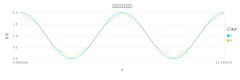

In [5]:
# f(x) = cos(x) + 1
f2(x) = cos.(x) .+ 1
a = 0
b = 4 * pi

# 13の標本点とその関数値
grid2 = linspace(a, b, 13)
vals2 = f2(grid2)

# plotがFunctionしか受け付けてくれないので関数化
oresen2 = LinearInterpolation.LinInterp(grid2, vals2)
g2(x) = oresen2.(x)

# plot
set_default_plot_size(24cm, 8cm)
plot([f2, g2], a, b, Guide.xticks(ticks=[a, b]), Guide.Title("複合台形則のイメージ"))

今度は, 関数  $f: \mathbb{R} \rightarrow \mathbb{R}$ の積分範囲 $[a, b]$ を $n$ 等分し, 

$$
\hat{T} = \sum_{i=0}^n \cfrac{f(x_i) + f(x_{i+1})}{2} (x_{i+1} - x_i) \hspace{20pt} x_0 = a, \ x_n = b
$$

として, $T$を近似することを考える. $x$のステップ幅を, $h = x_{i+1} - x_i,  \ \forall i \in \{0, 1, \ldots, n-1\}$ に固定すれば, 

$$
\hat{T} = h \left(  \frac{a}{2} + f(x_1) + f(x_2) + \ldots + f(x_{n-1}) + \frac{b}{2} \right)
$$



1ステップ毎の近似誤差が$O(h^3)$ であり, 一方で $h = \cfrac{b-a}{n}$ であるから, $T$ と $\hat{T}$ の差は, 

$$
T - \hat{T} = O(h^3) \times n = O(h^2)
$$

となる. つまり, 積分値の誤差はステップサイズの2乗に比例して小さくなることがわかる.

## 2. $\pi$ の計算法

まず, 

$$ \int_{0}^{1} \frac{1}{1 + x^2} = \frac{\pi}{4}$$

である. 

####（証明）

$x = tan \theta$ で置換すると, $\cfrac{dx}{d\theta} = \cfrac{1}{cos^2 \theta}$ であるので, 

$$
\begin{eqnarray}
\int_{0}^{1} \frac{1}{1 + x^2} &=& \int_{0}^{\frac{\pi}{4}} \frac{1}{1 + tan^2 \theta}\cfrac{dx}{d\theta}d\theta  \\
&=& \int_{0}^{\frac{\pi}{4}} cos^2 \theta\cfrac{1}{cos^2}d\theta \\
& = & \frac{\pi}{4}
\end{eqnarray}
$$

となる（証明終わり）.

$\cfrac{1}{1 + x^2}$ は $0 \leq x \leq 1$ で2回連続微分可能であるので, 複合台形則の誤差評価の式から, ステップサイズ$h$に対して誤差は$O(h^2)$ となり, $h$を半分にするたびに誤差は$\cfrac{1}{4}$になることがわかる.

## 3. 近似誤差の減少率

2 の結論を確かめる.

In [6]:
function calc_pi(size::Int64)
    func(x) = 1 ./ (1 .+ x.^2)
    step = 1 / size
    grid = linspace(0, 1, size+1)
    vals = func(grid)

    s = sum(vals[2:size]) + 0.5 * (vals[1] + vals[size+1])
    return step * s * 4
end

calc_pi (generic function with 1 method)

In [7]:
max_size = 25
for i in 1:max_size
    c = calc_pi(2^i)
    @printf "分割数: 2^%02d,   近似値: %.20f,  誤差: %.20f \n" i c (pi-c)
end

分割数: 2^01,   近似値: 3.10000000000000008882,  誤差: 0.04159265358979302718 
分割数: 2^02,   近似値: 3.13117647058823544981,  誤差: 0.01041618300155766619 
分割数: 2^03,   近似値: 3.13898849449108885423,  誤差: 0.00260415909870426177 
分割数: 2^04,   近似値: 3.14094161204138888621,  誤差: 0.00065104154840422979 
分割数: 2^05,   近似値: 3.14142989317497489665,  誤差: 0.00016276041481821935 
分割数: 2^06,   近似値: 3.14155196348565457498,  誤差: 0.00004069010413854102 
分割数: 2^07,   近似値: 3.14158248106375204145,  誤差: 0.00001017252604107455 
分割数: 2^08,   近似値: 3.14159011045828329145,  誤差: 0.00000254313150982455 
分割数: 2^09,   近似値: 3.14159201780691565986,  誤差: 0.00000063578287745614 
分割数: 2^10,   近似値: 3.14159249464407430708,  誤差: 0.00000015894571880892 
分割数: 2^11,   近似値: 3.14159261385336296968,  誤差: 0.00000003973643014632 
分割数: 2^12,   近似値: 3.14159264365568624555,  誤差: 0.00000000993410687045 
分割数: 2^13,   近似値: 3.14159265110626595430,  誤差: 0.00000000248352716170 
分割数: 2^14,   近似値: 3.14159265296891154762,  誤差: 0.00000000062088156838 
分割数: 2

In [8]:
x_list = Array{Int64}(max_size)
e_list = Array{Float64}(max_size)
for i in 1:max_size
    x_list[i] = 2^i
    e_list[i] = pi - calc_pi(2^i)
end

# plot
set_default_plot_size(16cm, 16cm)
plot(layer(x=x_list, y=e_list, Geom.point, Geom.line), 
        Scale.x_log2, Scale.y_log2, Guide.Title("複合台形則による誤差の減少"), 
        Guide.xlabel("split size"), Guide.ylabel("error")
)

ステップサイズが半分になる毎に, 誤差は1/4になっていることがわかる.